<a href="https://colab.research.google.com/github/ANUNAYBAGGA/Stock-Reserch/blob/main/StocksAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import os
import glob

path = 'gdrive/My Drive/stonks_DB'
extension = 'csv'
os.chdir(path) #Use for first time only
result = glob.glob('*.{}'.format(extension))
print(result)
db = {}
for i in result:
  db[i[:-4]] = pd.read_csv(i)

print(db.keys())
stocks = list(db.keys())

['ONGC.csv', 'GAIL.csv', 'MARUTI.csv', 'HEROMOTOCO.csv', 'NESTLEIND.csv', 'ULTRACEMCO.csv', 'HINDUNILVR.csv', 'IOC.csv', 'LT.csv', 'RELIANCE.csv', 'BPCL.csv', 'ADANIPORTS.csv', 'BAJFINANCE.csv', 'M&M.csv', 'INFY.csv', 'TCS.csv', 'NTPC.csv', 'HDFC.csv', 'JSWSTEEL.csv', 'HCLTECH.csv', 'POWERGRID.csv', 'SBIN.csv', 'SHREECEM.csv', 'TATASTEEL.csv', 'HINDALCO.csv', 'UPL.csv']
dict_keys(['ONGC', 'GAIL', 'MARUTI', 'HEROMOTOCO', 'NESTLEIND', 'ULTRACEMCO', 'HINDUNILVR', 'IOC', 'LT', 'RELIANCE', 'BPCL', 'ADANIPORTS', 'BAJFINANCE', 'M&M', 'INFY', 'TCS', 'NTPC', 'HDFC', 'JSWSTEEL', 'HCLTECH', 'POWERGRID', 'SBIN', 'SHREECEM', 'TATASTEEL', 'HINDALCO', 'UPL'])


In [4]:
#Weekly
def shift_returns(shift):
  days_to_shift = shift
  print(db.keys())
  for i in db.keys():
    shifted_db = db[i].shift(days_to_shift)
    returns = shifted_db['adjusted_close'] - db[i]['adjusted_close']
    log_returns = np.log(shifted_db['adjusted_close'] / db[i]['adjusted_close'])
    db[i]['return'] = returns
    db[i]['log_return'] = log_returns


Momentum Based Trading System.
Choose the top and bottom performers and then long and short them respectively.

In [5]:
#Momentum Trading
days = 690
shift_returns(5)
print(db['ONGC'].head(10))
table = []
for i in range(days):
  signal = [0 for i in range(len(stocks))]
  order = [db[x]['log_return'][i] for x in stocks]
  order = pd.DataFrame(order).nlargest(3,0).index
  for x in order:
    signal[x] = 1
  table.append(signal)
table = pd.DataFrame(table , columns = stocks)
#print(table)

count = [table[stock].value_counts()[1] for stock in stocks]
count = pd.DataFrame(count)
long_momentum = [stocks[x] for x in count.nlargest(3,0).index]
short_momentum = [stocks[x] for x in count.nsmallest(3,0).index]
print("Score for each stock : ")
#print(count)
map = {}
for i in range(len(stocks)):
  map[count[0][i]] = map.get(count[0][i] , []) + [stocks[i]]
tmp = list(map.keys())
tmp.sort()
tmp.reverse()
map_movement = {}
for i in tmp:
  print(map[i] , " : ", i/days)
  map_movement[map[i][0]] = i/days

print("Rising stocks, Top stocks to long are  : " , long_momentum)
print("Dropping stocks, Top stocks to short are : ", short_momentum)
print(map_movement)

dict_keys(['ONGC', 'GAIL', 'MARUTI', 'HEROMOTOCO', 'NESTLEIND', 'ULTRACEMCO', 'HINDUNILVR', 'IOC', 'LT', 'RELIANCE', 'BPCL', 'ADANIPORTS', 'BAJFINANCE', 'M&M', 'INFY', 'TCS', 'NTPC', 'HDFC', 'JSWSTEEL', 'HCLTECH', 'POWERGRID', 'SBIN', 'SHREECEM', 'TATASTEEL', 'HINDALCO', 'UPL'])
    timestamp    open    high  ...  split_coefficient  return  log_return
0  2021-03-05  116.25  118.20  ...                1.0     NaN         NaN
1  2021-03-04  113.80  117.05  ...                1.0     NaN         NaN
2  2021-03-03  114.45  115.90  ...                1.0     NaN         NaN
3  2021-03-02  116.00  116.65  ...                1.0     NaN         NaN
4  2021-03-01  114.40  117.50  ...                1.0     NaN         NaN
5  2021-02-26  115.90  118.40  ...                1.0    3.75    0.033182
6  2021-02-25  115.60  120.50  ...                1.0   -6.30   -0.054394
7  2021-02-24  113.80  115.50  ...                1.0    0.30    0.002636
8  2021-02-23  109.25  114.35  ...                1.0 

Pair Trading: Look at 2 or more stocks with similar traits and use that data to predict movement

In [6]:
#Pair Trading using Cosine Similarity
days = 690
table = []
i_count = 0
j_count = 0
for i in stocks:
  table.append([])
  j_count = 0
  for j in stocks:
      if i == j:
        table[-1].append(1)
        continue
      if i_count > j_count:
        table[-1].append(table[j_count][i_count])
        continue
      data1 = db[i]
      data2 = db[j]
      list_of_tuples = list(zip(data1["timestamp"], data1["log_return"][:days],data2["log_return"][:days]))
      
      tmp = pd.DataFrame(list_of_tuples, columns = ["time" , i , j])
      #tmp.plot(x = "time" , y = [i,j])
      #print(tmp.head(10))
      numerator = tmp[i] * tmp[j]
      numerator = numerator.sum(skipna = True)
      deno = ((tmp[i] ** 2 ).sum(skipna = True))**0.5 * ((tmp[j]**2).sum(skipna = True))**0.5
      #print("NUMERATOR " , deno)
      #print("SIMILARITY INDEX OF " , i , " AND ", j , " IS " , numerator/deno)
      table[-1].append(numerator/deno)
      j_count+=1
i_count = 0
    
print("SIMILARITY TABLE")
table = pd.DataFrame(table,columns = stocks,index=stocks)
print(table)
map_similarity = {}
for i in stocks:
  #print(table.nlargest(3,i))
  same = list(table.nlargest(4,i).index[1:])
  print("TOP 3 stocks like " , i , " are ",same)
  mean = db[same[0]]['log_return'].copy()
  for x in range(len(same)):
    mean+=db[same[x]]['log_return']
  mean/=3
  print("score =  " ,end = "")
  print(mean[5] - db[i]['log_return'][5])
  map_similarity[i] = mean[5] - db[i]['log_return'][5]
print(map_similarity)
  

SIMILARITY TABLE
                ONGC      GAIL    MARUTI  ...  TATASTEEL  HINDALCO       UPL
ONGC        1.000000  0.699631  0.319842  ...   0.581238  0.566895  0.354017
GAIL        0.699631  1.000000  0.350993  ...   0.552170  0.585707  0.415210
MARUTI      0.319842  0.350993  1.000000  ...   0.462458  0.488524  0.459683
HEROMOTOCO  0.323408  0.365177  0.636690  ...   0.321251  0.416104  0.344550
NESTLEIND   0.252852  0.293461  0.437543  ...   0.215924  0.280779  0.349026
ULTRACEMCO  0.449507  0.447082  0.550035  ...   0.515186  0.555634  0.460081
HINDUNILVR  0.276218  0.297187  0.424712  ...   0.242653  0.224925  0.272001
IOC         0.636200  0.561949  0.400358  ...   0.482663  0.449186  0.358474
LT          0.423787  0.460972  0.566122  ...   0.520816  0.599566  0.566311
RELIANCE    0.383129  0.379808  0.377748  ...   0.300404  0.355480  0.433454
BPCL        0.507724  0.501983  0.373870  ...   0.344879  0.408098  0.419716
ADANIPORTS  0.436652  0.424931  0.517684  ...   0.447827  0

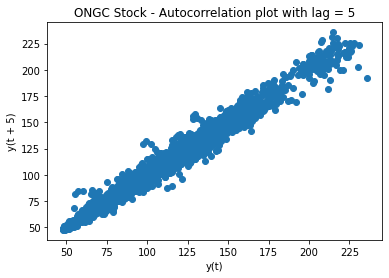

[124.915  128.7444 130.5011 ... 113.95   112.7    114.9   ] [ 51.3525  51.1856  49.3213 ... 126.9438 123.7782 125.1705]
115.01345980225561 51.3525
51.784913823357016 51.1856
52.49431650731132 49.3213
53.38787236636411 48.5018
47.43165406070699 48.9965
48.79750992061928 48.471000000000004
48.45375686823221 48.2667
48.201421852329844 48.035
48.03885265803271 48.7833
48.76044778227339 48.2018
48.17091873127137 48.3162
48.25362244489973 47.8988
47.90800622731541 47.6547
47.623576709541496 48.4059
48.39658721806959 48.1492
48.117889446351505 48.3874
48.31802983635917 48.8142
48.80133004357503 49.3182
49.26948403962559 50.6381
50.57645369829488 50.7837
50.716853890153615 50.6599
50.57261915752992 51.5317
51.514151341249466 51.0711
51.04770515485725 50.8423
50.777717883459225 50.6876
50.69777282978161 50.9258
50.909322769667995 50.5609
50.533729960681505 50.7495
50.71103395211817 50.9475
50.93670349834519 50.7063
50.66377571373683 49.7943
49.76482161466458 49.9981
49.99836396914814 49.8994
49

In [7]:
#Auto Regressive Integrated Moving Average (ARIMA) evaluation for ONGC
plt.figure()
lag_plot(db['ONGC']['adjusted_close'], lag=5)
plt.title('ONGC Stock - Autocorrelation plot with lag = 5')
plt.show()


train_data = db['ONGC'][0:int(len(db['ONGC']) * 0.7)].iloc[::-1]
test_data = db['ONGC'][int(len(db['ONGC']) * 0.7) : ].iloc[::-1]
training_data = train_data['adjusted_close'].values
test_data = test_data['adjusted_close'].values
print(training_data,test_data)
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
    #print(yhat , true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

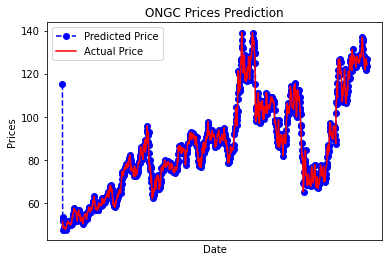

In [8]:
test_set_range = db['ONGC'][int(len(db['ONGC'])*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('ONGC Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(881,1259,500), db['ONGC'].timestamp[881:1259:500])
plt.legend()
plt.show()

3984     51.3525
3983     51.1856
3982     49.3213
3981     48.5018
3980     48.9965
          ...   
2793    125.5459
2792    126.1008
2791    126.9438
2790    123.7782
2789    125.1705
Name: adjusted_close, Length: 1196, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


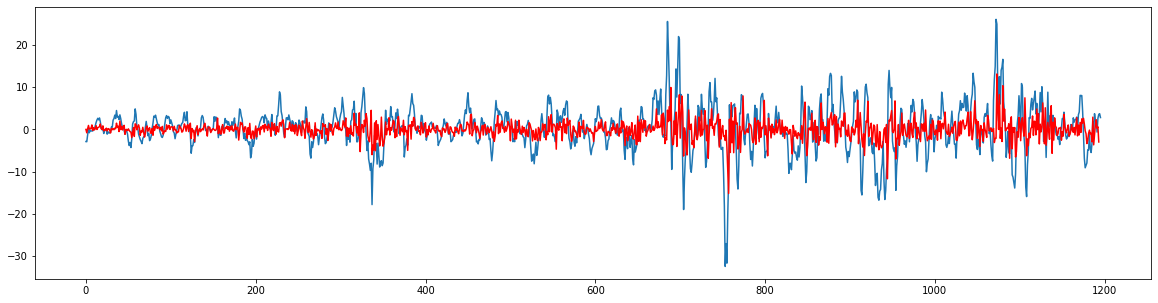

[-6.14972818e-01  2.98646610e+00 -1.48820218e+00 ...  1.43749871e-05
  1.43749871e-05  1.43749871e-05]
2789 2789


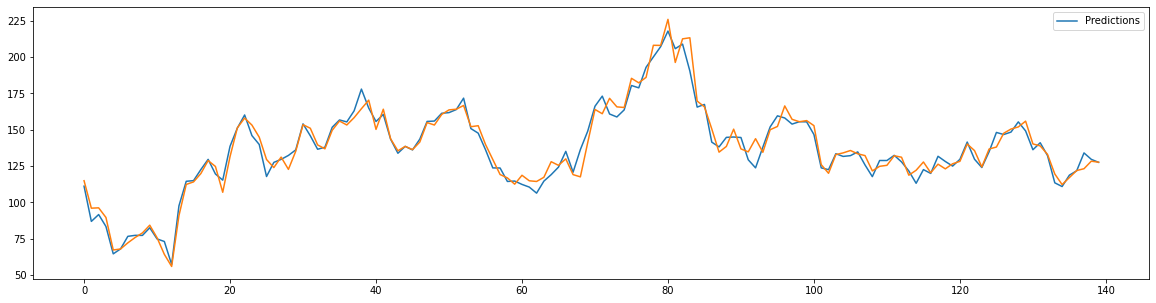

In [73]:
#Auto Regressive Integrated Moving Average (ARIMA) evaluation for ONGC forecasting
from collections import deque

test_data = db['ONGC'][int(len(db['ONGC']) * 0.7) : ].iloc[::-1]
train_data = db['ONGC'][0:int(len(db['ONGC']) * 0.7)].iloc[::-1]

test_y = train_data['adjusted_close'].values
test_data_return = test_data['return'].values
test_data_close = test_data['adjusted_close'].values
print(test_data['adjusted_close'])

model = ARIMA(test_data_close, order = (5,2,2))
results_AR = model.fit()  
plt.figure(figsize=(20,5))
plt.plot(test_data_return)
plt.plot(-1 * results_AR.fittedvalues, color='red')
plt.show()

y_pred = results_AR.predict(start=1194,end = len(test_y)+1193)
print(y_pred)
y_pred = -1 * y_pred
print(len(y_pred) , len(test_y))

test_y = deque([x for x in test_y])

for i in range(5,len(test_y)):
    y_pred[i] = y_pred[i] + test_y[i-5]
plt.figure(figsize=(20,5))
plt.plot(y_pred[::-20], label='Predictions')
#plt.plot(test_y.flatten()[2:], label='actual')
plt.plot(test_y1[::-20])
plt.legend()
plt.show()

In [ ]:
'''
# BOLLINGER BANDS 
days = 365
gap = days//10
mean = []
upar = []
neeche = []
for i in range(days):
  low = i-gap
  if low<0:
    low = 0
  mean.append(data["adjusted_close"][low:i+gap].mean())
  upar.append(mean[-1] + data["adjusted_close"][low:i+5].std())
  neeche.append(mean[-1] - data["adjusted_close"][low:i+5].std())

list_of_tuples = list(zip(data["timestamp"][:days][::-1], data["adjusted_close"][:days][::-1], mean[::-1], upar[::-1] , neeche[::-1]))  
tmp = pd.DataFrame(list_of_tuples,columns=["time","close","mean",'upar','neeche']  )
tmp.plot(x = "time" , y = ["close","mean",'upar','neeche'])

#SIMILARITY / PAIR TRADING

j = 'ONGC'
days = 365
for i in db.keys():
    if i!=j:
      data1 = db[i]
      data2 = db[j]
      list_of_tuples = list(zip(data1["timestamp"][:days][::-1], data1["log_return"][:days][::-1],data2["log_return"][:days][::-1]))
      
      tmp = pd.DataFrame(list_of_tuples, columns = ["time" , i , j])
      tmp.plot(x = "time" , y = [i,j])
  

SyntaxError: ignored